# Configuring model to fit to dataset

In [ ]:
!pip install pandas==2.2.2 matplotlib==3.9.0 mne==1.7.0 pymatreader==0.0.32 scikit-learn==1.5.0 PyQt6==6.7.0 PyQt6-Qt6==6.7.1 PyQt6-sip==13.6.0

In [ ]:
import pandas as pd
import numpy as np
import mne
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# import classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Load data

In [ ]:
class LoadData:
    psd_fmin = 0.2 # in Hertz
    psd_fmax = 45 # in Hertz
    psd_scale = 10e5
    psd_x_freqs = None

    def __init__(self, root, experiment_type: int, test_size: float = 0.2, random_state: int = 839, k_folds: int = 5):
        """
        ROOT: path to the root directory of the dataset

        Experiment type:
            1: Eyes Closed
            2: Eyes open
            3: Both
        """
        self.DATA_ROOT = root
        self.PARTICIPANTS_TSV = f'{self.DATA_ROOT}/participants.tsv'
        self.experiment_type = experiment_type

        # get class labels
        self.raw_labels = self.get_classes()
        self.labels = []

        # create data examples
        self.raw_data = []
        self.data = []
        self._create_eeg_objects()

        # holdout information
        self.test_size = test_size
        self.random_state = random_state

        # cross-validation information
        self.k_folds = k_folds
        self.split_participants = []

        # train and test data
        self.test = None
        self.train = None

        # split data
        self._cross_validation()


    def get_classes(self):
        participant_df = pd.read_csv(self.PARTICIPANTS_TSV, sep='\t')
        session_order = participant_df[['participant_id', 'SessionOrder']]

        # create ses-1 column based on the first two characters of the session order
        session_order['ses-1'] = session_order['SessionOrder'].str[:2]
        session_order['ses-2'] = session_order['SessionOrder'].str[4:]

        session_order = session_order.drop(columns=['SessionOrder'])

        session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
        session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

        return session_order

    def _create_eeg_objects(self):
        def load_raw_eeg(example, root, participant_id, session, task, class_label):
            try:
                aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data
                aux_psd = np.array(list(map(lambda x: 20*np.log10(x), aux_psd)))

                if class_label:
                    example[f"{task}_sd"] = (aux_psd, class_label)
                else:
                    example[f"{task}_ns"] = (aux_psd, class_label)
            except FileNotFoundError:
                print(f"For participant {participant_id}, the file {participant_id}_{session}_task-{task}_eeg.set was not found")
                aux_psd = None
            except RuntimeError as e:
                print(f"Error loading participant {participant_id} with session {session} and task {task}: {e}")
                aux_psd = None

            return example

        session_order = self.raw_labels

        for participant_id, ses_1, ses_2 in zip(session_order['participant_id'], session_order['ses-1'], session_order['ses-2']):
            example = dict()
            if self.experiment_type == 1:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
            elif self.experiment_type == 2:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)
            else:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)

            if len(example.keys()):
                example['participant_id'] = participant_id

            self.raw_data.append(example) if example.keys() else None

        self.raw_data = np.array(self.raw_data)


    def _holdout(self, participant_id, participant_index):
        X_train, X_test, y_train, y_test = train_test_split(participant_id, participant_index, test_size=self.test_size, random_state=self.random_state)
        return X_train, X_test, y_train, y_test

    def _cross_validation(self):
        participant_id = np.array([x['participant_id'] for x in self.raw_data])
        participant_index = np.arange(len(participant_id))

        _, _, y_train, y_test_id = self._holdout(participant_id, participant_index)

        # save test data
        X_test = [self.raw_data[i][col][0] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id']
        y_test = np.array([self.raw_data[i][col][1] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id'])
        self.test = (X_test, y_test)

        # create splits
        skf = KFold(n_splits=self.k_folds)
        self.split_participants = list(skf.split(y_train))


    def get_split_data(self, split):
        split_ids = self.split_participants[split]
        train_ids, val_ids = split_ids

        X_train =[self.raw_data[i][col][0] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_train = np.array([self.raw_data[i][col][1] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id'])

        X_val = [self.raw_data[i][col][0] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_val = np.array([self.raw_data[i][col][1] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id'])

        return X_train, X_val, y_train, y_val

    def __len__(self):
        return len(self.raw_data)

In [ ]:
# connect to google
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install patool

In [ ]:
import patoolib

In [ ]:
# patoolib.extract_archive('/content/drive/MyDrive/ufes/ds004902-download.zip')

In [ ]:
DATA_TYPE = 3 # 1 = Closed eyes 2 = Opened eyes 3 = Both

In [ ]:
dataset = LoadData('/content/Unpack_w73geyxp/ds004902-download', DATA_TYPE)

Reading /content/Unpack_w73geyxp/ds004902-download/sub-01/ses-1/eeg/sub-01_ses-1_task-eyesclosed_eeg.fdt


<ipython-input-161-9a0717435d70>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-1'] = session_order['SessionOrder'].str[:2]
<ipython-input-161-9a0717435d70>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-2'] = session_order['SessionOrder'].str[4:]


Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-01/ses-2/eeg/sub-01_ses-2_task-eyesclosed_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-01/ses-1/eeg/sub-01_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-01/ses-2/eeg/sub-01_ses-2_task-eyesopen_eeg.fdt
Error loading participant sub-01 with session ses-2 and task eyesopen: Incorrect number of samples (6951331 != 9150000), please report this error to MNE-Python developers
Reading /content/Unpack_w73geyxp/ds004902-download/sub-02/ses-1/eeg/sub-02_ses-1_task-eyesclosed_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-02/ses-2/eeg/sub-02_ses-2_task-eyesclosed_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-02/ses-1/eeg/sub-02_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
R

<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-47, the file sub-47_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-47, the file sub-47_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-47/ses-1/eeg/sub-47_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-47/ses-2/eeg/sub-47_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-48, the file sub-48_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-48, the file sub-48_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-48/ses-1/eeg/sub-48_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-48/ses-2/eeg/sub-48_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-49, the file sub-49_ses-1_task-eyesclosed_eeg.set was not foun

<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-52, the file sub-52_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-52, the file sub-52_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-52/ses-1/eeg/sub-52_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-52/ses-2/eeg/sub-52_ses-2_task-eyesopen_eeg.fdt


<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-53, the file sub-53_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-53, the file sub-53_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-53/ses-1/eeg/sub-53_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-53/ses-2/eeg/sub-53_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-54, the file sub-54_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-54, the file sub-54_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-54/ses-1/eeg/sub-54_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-54/ses-2/eeg/sub-54_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-55, the file sub-55_ses-1_task-eyesclosed_eeg.set was not foun

<ipython-input-161-9a0717435d70>:63: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data
<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-57/ses-2/eeg/sub-57_ses-2_task-eyesopen_eeg.fdt


<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-58, the file sub-58_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-58, the file sub-58_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-58/ses-1/eeg/sub-58_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-58/ses-2/eeg/sub-58_ses-2_task-eyesopen_eeg.fdt


<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-59, the file sub-59_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-59, the file sub-59_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-59/ses-1/eeg/sub-59_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-59/ses-2/eeg/sub-59_ses-2_task-eyesopen_eeg.fdt


<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-60, the file sub-60_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-60, the file sub-60_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-60/ses-1/eeg/sub-60_ses-1_task-eyesopen_eeg.fdt


<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-60/ses-2/eeg/sub-60_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-61, the file sub-61_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-61, the file sub-61_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-61/ses-1/eeg/sub-61_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-61/ses-2/eeg/sub-61_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-62, the file sub-62_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-62, the file sub-62_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-62/ses-1/eeg/sub-62_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-62/ses-2/eeg/sub-62_ses-2_t

<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-63, the file sub-63_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-63, the file sub-63_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-63/ses-1/eeg/sub-63_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-63/ses-2/eeg/sub-63_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-64, the file sub-64_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-64, the file sub-64_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-64/ses-1/eeg/sub-64_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-64/ses-2/eeg/sub-64_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-65, the file sub-65_ses-1_task-eyesclosed_eeg.set was not foun

<ipython-input-161-9a0717435d70>:63: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_psd = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=self.psd_fmin, fmax=self.psd_fmax).data


Effective window size : 4.096 (s)
For participant sub-66, the file sub-66_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-66, the file sub-66_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-66/ses-1/eeg/sub-66_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-66/ses-2/eeg/sub-66_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-67, the file sub-67_ses-1_task-eyesclosed_eeg.set was not found
For participant sub-67, the file sub-67_ses-2_task-eyesclosed_eeg.set was not found
Reading /content/Unpack_w73geyxp/ds004902-download/sub-67/ses-1/eeg/sub-67_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
Reading /content/Unpack_w73geyxp/ds004902-download/sub-67/ses-2/eeg/sub-67_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
For participant sub-68, the file sub-68_ses-1_task-eyesclosed_eeg.set was not foun

In [ ]:
sum_type = {"open_sd": 0, "open_ns": 0, "closed_sd": 0, "closed_ns": 0}
for example in dataset.raw_data:
    if "eyesopen_sd" in example:
        sum_type["open_sd"] += 1
    if "eyesopen_ns" in example:
        sum_type["open_ns"] += 1
    if "eyesclosed_sd" in example:
        sum_type["closed_sd"] += 1
    if "eyesclosed_ns" in example:
        sum_type["closed_ns"] += 1

In [ ]:
sum_type

{'open_sd': 70, 'open_ns': 68, 'closed_sd': 36, 'closed_ns': 38}

In [ ]:
for d in dataset.raw_data:
    if "eyesopen_sd" in d:
        print(d['eyesopen_sd'][0].shape)
    if "eyesopen_ns" in d:
        print(d['eyesopen_ns'][0].shape)
    if "eyesclosed_sd" in d:
        print(d['eyesclosed_sd'][0].shape)
    if "eyesclosed_ns" in d:
        print(d['eyesclosed_ns'][0].shape)

(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)
(61, 184)


## Aux function

In [ ]:
def _remove_data_few_freq(data, label):
    label = [l for d, l in zip(data, label) if d.shape[1] == data[0].shape[1]]
    data = [d for d in data  if d.shape[1] == data[0].shape[1]]
    return data, label

In [ ]:
# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
import pickle

def save_model(filename, model):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

## Gridsearch SVC

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
scaler = StandardScaler()

In [ ]:
# SVC hyperparams
C = [0.1, 1, 10, 100]
gamma = [1, 0.1, 0.01, 0.001, 'scale']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

param_grid = {'C': C, 'gamma': gamma, 'kernel': kernel}
param_grid = ParameterGrid(param_grid)

In [ ]:
svc_score = 0
best_svc_model = None
results_svc = []
for i in range(dataset.k_folds):
    print(f"\nSplit {i + 1}")

    X_train, X_val, y_train, y_val = dataset.get_split_data(i)
    print("Before filtering bad data formatg")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}", end='\n')

    X_train, y_train = _remove_data_few_freq(X_train, y_train)
    X_val, y_val = _remove_data_few_freq(X_val, y_val)

    # standardize data using z-score per channel
    X_train = np.array(X_train)
    X_val = np.array(X_val)

    flattened_X_train = X_train.reshape(X_train.shape[0], -1)
    flattened_X_val = X_val.reshape(X_val.shape[0], -1)

    flattened_X_train = scaler.fit_transform(flattened_X_train)
    flattened_X_val = scaler.transform(flattened_X_val)

    print(f"Train: {flattened_X_train.shape}")
    print(f"Val: {flattened_X_val.shape}", end='\n\n')

    for params in param_grid:
        grid_svc = SVC(**params)
        print(f"C: {params['C']} - Gamma: {params['gamma']} - Kernel {params['kernel']}",end=' ')
        grid_svc.fit(flattened_X_train, y_train)
        score = grid_svc.score(flattened_X_val, y_val)
        pred = grid_svc.predict(flattened_X_val)

        recall = recall_score(y_val, pred)
        precision = precision_score(y_val, pred)

        print(f"- Accuracy: {score}")
        print(f"- Recall: {recall}")
        print(f"- Precision: {precision}")

        result = dict(params)
        result['score'] = score
        result['recall'] = recall
        result['precision'] = precision
        result['cv'] = i
        results_svc.append(result)

        save_model(f"models/data_{DATA_TYPE}/svc_cv{i}_{params['C']}_{params['gamma']}_{params['kernel']}.pkl", grid_svc)

        if score > svc_score:
            svc_score = score
            best_svc_model = grid_svc


Split 1
Before filtering bad data formatg
Train: 137
Val: 45
Train: (135, 11224)
Val: (45, 11224)

C: 0.1 - Gamma: 1 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 0.1 - Gamma: 1 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 0.1 - Gamma: 1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.5111111111111111
- Recall: 0.45454545454545453
- Precision: 0.5
C: 0.1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 0.1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 0.1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5111111111111111
- Recall: 0.45454545454545453
- Precision: 0.5
C: 0.1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 0.1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 0.1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5555555555555556
- Recall: 0.45454545454545453
- Precision: 0.5555555555555556
C: 0.1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 0.1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 0.1 - Gamma: 0.001 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5111111111111111
- Recall: 0.22727272727272727
- Precision: 0.5
C: 0.1 - Gamma: scale - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 0.1 - Gamma: scale - Kernel poly - Accuracy: 0.4444444444444444
- Recall: 0.3181818181818182
- Precision: 0.4117647058823529
C: 0.1 - Gamma: scale - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: scale - Kernel sigmoid 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 1 - Gamma: 1 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 1 - Gamma: 1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.4666666666666667
- Recall: 0.2727272727272727
- Precision: 0.42857142857142855
C: 1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5111111111111111
- Recall: 0.3181818181818182
- Precision: 0.5
C: 1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5333333333333333
- Recall: 0.3181818181818182
- Precision: 0.5384615384615384
C: 1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 1 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5111111111111111
- Recall: 0.045454545454545456
- Precision: 0.5
C: 1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.4888888888888889
- Recall: 0.3181818181818182
- Precision: 0.4666666666666667
C: 1 - Gamma: scale - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 1 - Gamma: scale - Kernel poly - Accuracy: 0.37777777777777777
- Recall: 0.22727272727272727
- Precision: 0.3125
C: 1 - Gamma: scale - Kernel rbf - Accuracy: 0.4222222222222222
- Recall: 0.6363636363636364
- Prec

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.4888888888888889
- Recall: 0.3181818181818182
- Precision: 0.4666666666666667
C: 10 - Gamma: 0.1 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 10 - Gamma: 0.1 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 10 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5111111111111111
- Recall: 0.2727272727272727
- Precision: 0.5
C: 10 - Gamma: 0.01 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 10 - Gamma: 0.01 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 10 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.4888888888888889
- Recall: 0.2727272727272727
- Precision: 0.46153846153846156
C: 10 - Gamma: 0.001 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 10 - Gamma: 0.001 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 10 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5111111111111111
- Recall: 0.045454545454545456
- Precision: 0.5
C: 10 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5333333333333333
- Recall: 0.3181818181818182
- Precision: 0.5384615384615384
C: 10 - Gamma: scale - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 10 - Gamma: scale - Kernel poly - Accuracy: 0.5111111111111111
- Recall: 0.8636363636363636
- Precision: 0.5
C: 10 - Gamma: scale - Kernel rbf - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.5111111111111111
- Recall: 0.36363636363636365
- Precision: 0.5
C: 100 - Gamma: 0.1 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 100 - Gamma: 0.1 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 100 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.4888888888888889
- Recall: 0.3181818181818182
- Precision: 0.4666666666666667
C: 100 - Gamma: 0.01 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 100 - Gamma: 0.01 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 100 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5111111111111111
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.4888888888888889
- Recall: 0.2727272727272727
- Precision: 0.46153846153846156
C: 100 - Gamma: 0.001 - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 100 - Gamma: 0.001 - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 100 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5111111111111111
- Recall: 0.045454545454545456
- Precision: 0.5
C: 100 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.4666666666666667
- Recall: 0.3181818181818182
- Precision: 0.4375
C: 100 - Gamma: scale - Kernel linear - Accuracy: 0.4222222222222222
- Recall: 0.36363636363636365
- Precision: 0.4
C: 100 - Gamma: scale - Kernel poly - Accuracy: 0.4222222222222222
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 100 - Gamma: scale - Kernel rbf - Accuracy: 0.4444444444444444
- Recall: 0.40909090

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.38636363636363635
- Recall: 0.36363636363636365
- Precision: 0.38095238095238093
C: 0.1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 0.1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 0.1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.36363636363636365
- Recall: 0.3181818181818182
- Precision: 0.35
C: 0.1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 0.1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 0.1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.4318181818181818
- Recall: 0.3181818181818182
- Precision: 0.4117647058823529
C: 0.1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 0.1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 0.1 - Gamma: 0.001 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.45454545454545453
- Recall: 0.3181818181818182
- Precision: 0.4375
C: 0.1 - Gamma: scale - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 0.1 - Gamma: scale - Kernel poly - Accuracy: 0.4772727272727273
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: scale - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: scale - Kernel sigmoid - Accuracy: 0.4772727272727273
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 1 - Gamma: 1 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 1 - Gamma: 1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.4318181818181818
- Recall: 0.45454545454545453
- Precision: 0.43478260869565216
C: 1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.4318181818181818
- Recall: 0.4090909090909091
- Precision: 0.42857142857142855
C: 1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5909090909090909
- Recall: 0.5909090909090909
- Precision: 0.5909090909090909
C: 1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 1 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5
- Recall: 0.18181818181818182
- Precision: 0.5
C: 1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.3181818181818182
- Recall: 0.36363636363636365
- Precision: 0.3333333333333333
C: 1 - Gamma: scale - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 1 - Gamma: scale - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.045454545454545456
- Precision: 0.25
C: 1 - Gamma: scale - Kernel rbf - Accuracy: 0.45454545454545453
- Recall: 0.45454545454545453
- Prec

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.4090909090909091
- Recall: 0.4090909090909091
- Precision: 0.4090909090909091
C: 10 - Gamma: 0.1 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 10 - Gamma: 0.1 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 10 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.45454545454545453
- Recall: 0.45454545454545453
- Precision: 0.45454545454545453
C: 10 - Gamma: 0.01 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 10 - Gamma: 0.01 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 10 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5909090909090909
- Recall: 0.6363636363636364
- Precision: 0.5833333333333334
C: 10 - Gamma: 0.001 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 10 - Gamma: 0.001 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 10 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.4772727272727273
- Recall: 0.2727272727272727
- Precision: 0.46153846153846156
C: 10 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.3181818181818182
- Recall: 0.4090909090909091
- Precision: 0.34615384615384615
C: 10 - Gamma: scale - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 10 - Gamma: scale - Kernel poly - Accuracy: 0.4090909090909091
- Recall: 0.6818181818181818
- Precision: 0.4411764705882353
C: 10 - Gamma: scale - Kernel rbf - Accuracy: 0.43181

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.4090909090909091
- Recall: 0.4090909090909091
- Precision: 0.4090909090909091
C: 100 - Gamma: 0.1 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 100 - Gamma: 0.1 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 100 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.4318181818181818
- Recall: 0.5
- Precision: 0.44
C: 100 - Gamma: 0.01 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 100 - Gamma: 0.01 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 100 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5454545454545454
- Recall: 0.5454545454545454
- Precision: 0.5454545454545454
C: 100 - Gamma: 0.001 - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 100 - Gamma: 0.001 - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 100 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.4772727272727273
- Recall: 0.2727272727272727
- Precision: 0.46153846153846156
C: 100 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.38636363636363635
- Recall: 0.5
- Precision: 0.4074074074074074
C: 100 - Gamma: scale - Kernel linear - Accuracy: 0.38636363636363635
- Recall: 0.4090909090909091
- Precision: 0.391304347826087
C: 100 - Gamma: scale - Kernel poly - Accuracy: 0.45454545454545453
- Recall: 0.6363636363636364
- Precision: 0.4666666666666667
C: 100 - Gamma: scale - Kernel rbf - Accuracy: 0.40909090909

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.47619047619047616
- Recall: 0.47619047619047616
- Precision: 0.47619047619047616
C: 0.1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 0.1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 0.1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5238095238095238
- Recall: 0.42857142857142855
- Precision: 0.5294117647058824
C: 0.1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 0.1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 0.1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.42857142857142855
- Recall: 0.2857142857142857
- Precision: 0.4
C: 0.1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 0.1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 0.1 - Gamma: 0.001 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.4523809523809524
- Recall: 0.38095238095238093
- Precision: 0.4444444444444444
C: 0.1 - Gamma: scale - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 0.1 - Gamma: scale - Kernel poly - Accuracy: 0.5238095238095238
- Recall: 0.19047619047619047
- Precision: 0.5714285714285714
C: 0.1 - Gamma: scale - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: scale - Kernel sigmoid 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 1 - Gamma: 1 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 1 - Gamma: 1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.47619047619047616
- Recall: 0.38095238095238093
- Precision: 0.47058823529411764
C: 1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.38095238095238093
- Precision: 0.5
C: 1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.4523809523809524
- Recall: 0.38095238095238093
- Precision: 0.4444444444444444
C: 1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 1 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5
- Recall: 0.14285714285714285
- Precision: 0.5
C: 1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.42857142857142855
- Precision: 0.5
C: 1 - Gamma: scale - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 1 - Gamma: scale - Kernel poly - Accuracy: 0.47619047619047616
- Recall: 0.14285714285714285
- Precision: 0.42857142857142855
C: 1 - Gamma: scale - Kernel rbf - Accuracy: 0.47619047619047616
- Recall: 0.38095238095238093
- Precision: 0.47058823529411764
C: 1 - Gamma: scale

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.47619047619047616
- Recall: 0.38095238095238093
- Precision: 0.47058823529411764
C: 10 - Gamma: 0.1 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 10 - Gamma: 0.1 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 10 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.42857142857142855
- Precision: 0.5
C: 10 - Gamma: 0.01 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 10 - Gamma: 0.01 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 10 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.47619047619047616
- Recall: 0.42857142857142855
- Precision: 0.47368421052631576
C: 10 - Gamma: 0.001 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 10 - Gamma: 0.001 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 10 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5238095238095238
- Recall: 0.23809523809523808
- Precision: 0.5555555555555556
C: 10 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5714285714285714
- Recall: 0.5238095238095238
- Precision: 0.5789473684210527
C: 10 - Gamma: scale - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 10 - Gamma: scale - Kernel poly - Accuracy: 0.5238095238095238
- Recall: 0.8095238095238095
- Precision: 0.5151515151515151
C: 10 - Gamma: scale - Kernel rbf - Accuracy: 0.4523809523809524
- Recall: 0.38095

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.47619047619047616
- Recall: 0.38095238095238093
- Precision: 0.47058823529411764
C: 100 - Gamma: 0.1 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 100 - Gamma: 0.1 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 100 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.42857142857142855
- Precision: 0.5
C: 100 - Gamma: 0.01 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 100 - Gamma: 0.01 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 100 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.42857142857142855
- Precision: 0.5
C: 100 - Gamma: 0.001 - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 100 - Gamma: 0.001 - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 100 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5238095238095238
- Recall: 0.23809523809523808
- Precision: 0.5555555555555556
C: 100 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5238095238095238
- Recall: 0.47619047619047616
- Precision: 0.5263157894736842
C: 100 - Gamma: scale - Kernel linear - Accuracy: 0.5952380952380952
- Recall: 0.5238095238095238
- Precision: 0.6111111111111112
C: 100 - Gamma: scale - Kernel poly - Accuracy: 0.5
- Recall: 0.7142857142857143
- Precision: 0.5
C: 100 - Gamma: scale - Kernel rbf - Accuracy: 0.4523809523809524
- Recall: 0.38095238095238093
- Precision: 0.4444444444444444
C: 100 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5185185185185185
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.5555555555555556
- Recall: 0.5384615384615384
- Precision: 0.5384615384615384
C: 0.1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.5185185185185185
- Recall: 0.6153846153846154
- Precision: 0.5
C: 0.1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.4074074074074074
- Recall: 0.46153846153846156
- Precision: 0.4
C: 0.1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5185185185185185
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.48148148148148145
- Recall: 0.5384615384615384
- Precision: 0.4666666666666667
C: 0.1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.5185185185185185
- Recall: 0.6153846153846154
- Precision: 0.5
C: 0.1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.4074074074074074
- Recall: 0.46153846153846156
- Precision: 0.4
C: 0.1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5185185185185185
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5925925925925926
- Recall: 0.5384615384615384
- Precision: 0.5833333333333334
C: 0.1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.5185185185185185
- Recall: 0.6153846153846154
- Precision: 0.5
C: 0.1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.4074074074074074
- Recall: 0.46153846153846156
- Precision: 0.4
C: 0.1 - Gamma: 0.001 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5185185185185185
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5555555555555556
- Recall: 0.46153846153846156
- Precision: 0.5454545454545454
C: 0.1 - Gamma: scale - Kernel linear - Accuracy: 0.5185185185185185
- Recall: 0.6153846153846154
- Precision: 0.5
C: 0.1 - Gamma: scale - Kernel poly - Accuracy: 0.5555555555555556
- Recall: 0.15384615384615385
- Precision: 0.6666666666666666
C: 0.1 - Gamma: scale - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5185185185185185
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: scale - Kernel sigmoid 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5185185185185185
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel linear - Accuracy: 0.5185185185185185
- Recall: 0.6153846153846154
- Precision: 0.5
C: 1 - Gamma: 1 - Kernel poly - Accuracy: 0.4074074074074074
- Recall: 0.46153846153846156
- Precision: 0.4
C: 1 - Gamma: 1 - Kernel rbf - Accuracy: 0.48148148148148145
- Recall: 1.0
- Precision: 0.48148148148148145
C: 1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.5555555555555556
- Recall: 0.6153846153846154
- Precision: 0.5333333333333333
C: 1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.5185185185185185
- Recall: 0.6153846153846154
- Precision: 0.5
C: 1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.4074074074074074
- Recall: 0.46153846153846156
- Precision: 0.4
C: 1 - Gamma: 0.1 - Kernel rbf - Accuracy: 0.48148148148148145
- Recall: 1.0
- Precision: 0.48148148148148145
C: 1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.48148148148148145
- Recall: 0.5384615384615384
- Precision: 0.4666666666666667
C: 1 - Gamma: 0.01 - Kernel l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.45454545454545453
- Recall: 0.45454545454545453
- Precision: 0.45454545454545453
C: 0.1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 0.1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 0.1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.4090909090909091
- Recall: 0.45454545454545453
- Precision: 0.4166666666666667
C: 0.1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 0.1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 0.1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.3181818181818182
- Recall: 0.2727272727272727
- Precision: 0.3
C: 0.1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 0.1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 0.1 - Gamma: 0.001 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5909090909090909
- Recall: 0.36363636363636365
- Precision: 0.6666666666666666
C: 0.1 - Gamma: scale - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 0.1 - Gamma: scale - Kernel poly - Accuracy: 0.5
- Recall: 0.36363636363636365
- Precision: 0.5
C: 0.1 - Gamma: scale - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 0.1 - Gamma: scale - Kernel sigmoid 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 1 - Gamma: 1 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 1 - Gamma: 1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 1 - Gamma: 0.1 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 1 - Gamma: 0.1 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 1 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.45454545454545453
- Precision: 0.5
C: 1 - Gamma: 0.01 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 1 - Gamma: 0.01 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 1 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 1 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.6363636363636364
- Recall: 0.6363636363636364
- Precision: 0.6363636363636364
C: 1 - Gamma: 0.001 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 1 - Gamma: 0.001 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 1 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.5
- Recall: 0.09090909090909091
- Precision: 0.5
C: 1 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.45454545454545453
- Precision: 0.5
C: 1 - Gamma: scale - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 1 - Gamma: scale - Kernel poly - Accuracy: 0.5
- Recall: 0.45454545454545453
- Precision: 0.5
C: 1 - Gamma: scale - Kernel rbf - Accuracy: 0.4090909090909091
- Recall: 0.45454545454545453
- Precision: 0.4166666666666667
C: 1 - Gamma: sca

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 10 - Gamma: 0.1 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 10 - Gamma: 0.1 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 10 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5909090909090909
- Recall: 0.6363636363636364
- Precision: 0.5833333333333334
C: 10 - Gamma: 0.01 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 10 - Gamma: 0.01 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 10 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 10 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.5909090909090909
- Recall: 0.5454545454545454
- Precision: 0.6
C: 10 - Gamma: 0.001 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 10 - Gamma: 0.001 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 10 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.45454545454545453
- Recall: 0.09090909090909091
- Precision: 0.3333333333333333
C: 10 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.5454545454545454
- Precision: 0.5
C: 10 - Gamma: scale - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 10 - Gamma: scale - Kernel poly - Accuracy: 0.4090909090909091
- Recall: 0.7272727272727273
- Precision: 0.4444444444444444
C: 10 - Gamma: scale - Kernel rbf - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 1 - Kernel sigmoid - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 100 - Gamma: 0.1 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 100 - Gamma: 0.1 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 100 - Gamma: 0.1 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.1 - Kernel sigmoid - Accuracy: 0.5909090909090909
- Recall: 0.5454545454545454
- Precision: 0.6
C: 100 - Gamma: 0.01 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 100 - Gamma: 0.01 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 100 - Gamma: 0.01 - Kernel rbf 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Accuracy: 0.5
- Recall: 0.0
- Precision: 0.0
C: 100 - Gamma: 0.01 - Kernel sigmoid - Accuracy: 0.6363636363636364
- Recall: 0.6363636363636364
- Precision: 0.6363636363636364
C: 100 - Gamma: 0.001 - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 100 - Gamma: 0.001 - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 100 - Gamma: 0.001 - Kernel rbf - Accuracy: 0.45454545454545453
- Recall: 0.09090909090909091
- Precision: 0.3333333333333333
C: 100 - Gamma: 0.001 - Kernel sigmoid - Accuracy: 0.5
- Recall: 0.5454545454545454
- Precision: 0.5
C: 100 - Gamma: scale - Kernel linear - Accuracy: 0.45454545454545453
- Recall: 0.5454545454545454
- Precision: 0.46153846153846156
C: 100 - Gamma: scale - Kernel poly - Accuracy: 0.36363636363636365
- Recall: 0.45454545454545453
- Precision: 0.38461538461538464
C: 100 - Gamma: scale - Kernel rbf - Accuracy: 0.36363636363636365


In [ ]:
svc_score

0.6818181818181818

In [ ]:
df_svc = pd.DataFrame(results_svc)
df_svc.head()

,C,gamma,kernel,score,recall,precision,cv
0,0.1,1,linear,0.422222,0.363636,0.400000,0
1,0.1,1,poly,0.422222,0.727273,0.444444,0
2,0.1,1,rbf,0.511111,0.000000,0.000000,0
3,0.1,1,sigmoid,0.511111,0.454545,0.500000,0
4,0.1,0.1,linear,0.422222,0.363636,0.400000,0


In [ ]:
df_svc = df_svc.sort_values(by='score', ascending=False)
df_svc.to_csv(f"models/data_{DATA_TYPE}/svc_results.csv", index=False)

In [ ]:
top_10_svc = df_svc.sort_values(by='score', ascending=False)[0:10]

In [ ]:
top_10_svc

,C,gamma,kernel,score,recall,precision,cv
399,100.0,scale,sigmoid,0.681818,0.636364,0.700000,4
278,1.0,scale,rbf,0.666667,0.692308,0.642857,3
391,100.0,0.01,sigmoid,0.636364,0.636364,0.636364,4
351,1.0,0.01,sigmoid,0.636364,0.636364,0.636364,4
208,10.0,0.01,linear,0.595238,0.523810,0.611111,2
164,0.1,0.1,linear,0.595238,0.523810,0.611111,2
236,100.0,scale,linear,0.595238,0.523810,0.611111,2
232,100.0,0.001,linear,0.595238,0.523810,0.611111,2
228,100.0,0.01,linear,0.595238,0.523810,0.611111,2
224,100.0,0.1,linear,0.595238,0.523810,0.611111,2


In [ ]:
best_svc_model

SVC(C=100, kernel='sigmoid')

In [ ]:
# apply test
X_test, y_test = dataset.test
X_test, y_test = _remove_data_few_freq(X_test, y_test)
X_test = np.array(X_test)
flattened_X_test = X_test.reshape(X_test.shape[0], -1)
flattened_X_test = scaler.transform(flattened_X_test)


best_svc_model.score(flattened_X_test, y_test)

0.5434782608695652

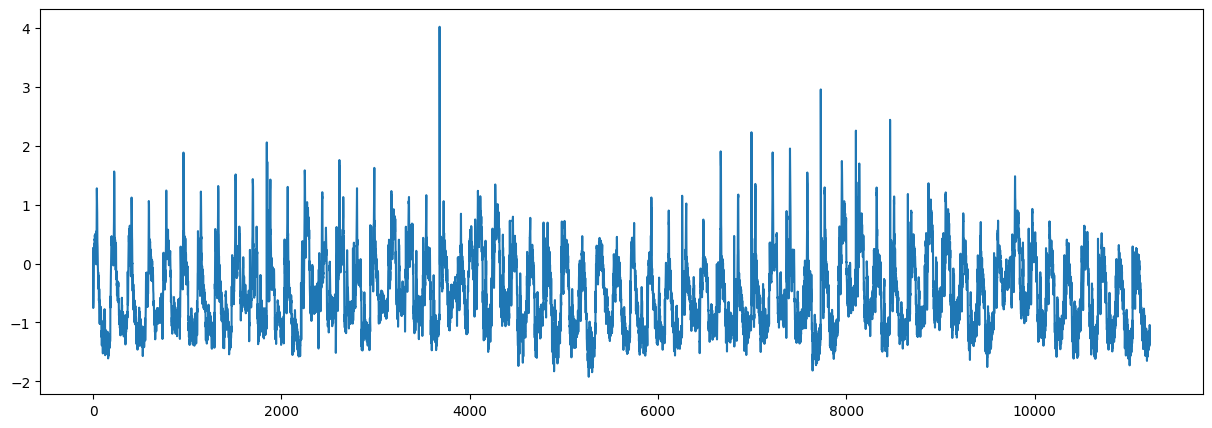

In [ ]:
# plot flattened_X_test[0]
plt.figure(figsize=(15, 5))
plt.plot(flattened_X_test[0])
plt.show()

In [ ]:
# load model
# loop row in dataframe
best_models_results = []
for _, row in top_10_svc.iterrows():
    cv_param = row['cv']
    c_param = row['C']
    gamma_param = row['gamma']
    kernel_param = row['kernel']

    c_int = int(c_param) == float(c_param)
    if c_int:
        c_param = int(c_param)

    with open(f"models/data_{DATA_TYPE}/svc_cv{cv_param}_{c_param}_{gamma_param}_{kernel_param}.pkl", 'rb') as f:
        model = pickle.load(f)

    print(f"Params: C={c_param}, gamma={gamma_param}, kernel={kernel_param}")
    pred = model.predict(flattened_X_test)
    score = model.score(flattened_X_test, y_test)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)

    print(f"Accuracy: {score}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}\n")

    result = dict(row)
    result['score'] = score
    result['recall'] = recall
    result['precision'] = precision
    best_models_results.append(result)

Params: C=100, gamma=scale, kernel=sigmoid
Accuracy: 0.5434782608695652
Recall: 0.5652173913043478
Precision: 0.5416666666666666

Params: C=1, gamma=scale, kernel=rbf
Accuracy: 0.8043478260869565
Recall: 0.782608695652174
Precision: 0.8181818181818182

Params: C=100, gamma=0.01, kernel=sigmoid
Accuracy: 0.5
Recall: 0.4782608695652174
Precision: 0.5

Params: C=1, gamma=0.01, kernel=sigmoid
Accuracy: 0.5
Recall: 0.4782608695652174
Precision: 0.5

Params: C=10, gamma=0.01, kernel=linear
Accuracy: 0.8260869565217391
Recall: 0.8695652173913043
Precision: 0.8

Params: C=0.1, gamma=0.1, kernel=linear
Accuracy: 0.8260869565217391
Recall: 0.8695652173913043
Precision: 0.8

Params: C=100, gamma=scale, kernel=linear
Accuracy: 0.8260869565217391
Recall: 0.8695652173913043
Precision: 0.8

Params: C=100, gamma=0.001, kernel=linear
Accuracy: 0.8260869565217391
Recall: 0.8695652173913043
Precision: 0.8

Params: C=100, gamma=0.01, kernel=linear
Accuracy: 0.8260869565217391
Recall: 0.8695652173913043
Pr

In [ ]:
df_best_svc = pd.DataFrame(best_models_results)
df_best_svc.head()

,C,gamma,kernel,score,recall,precision,cv
0,100.0,scale,sigmoid,0.543478,0.565217,0.541667,4
1,1.0,scale,rbf,0.804348,0.782609,0.818182,3
2,100.0,0.01,sigmoid,0.500000,0.478261,0.500000,4
3,1.0,0.01,sigmoid,0.500000,0.478261,0.500000,4
4,10.0,0.01,linear,0.826087,0.869565,0.800000,2


## Gridsearch KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:

# KNN hyperparams
n_neighbors = [2]
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute']
metric = ['euclidean', 'manhattan', 'minkowski']

param_grid = {'n_neighbors': n_neighbors, 'weights': weights, 'algorithm': algorithm, 'metric': metric}
param_grid = ParameterGrid(param_grid)

In [ ]:
knn_score = 0
best_knn_model = None
results_knn = []
for i in range(dataset.k_folds):
    print(f"\nSplit {i + 1}")

    X_train, X_val, y_train, y_val = dataset.get_split_data(i)
    print("Before filtering bad data formatg")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}", end='\n')

    X_train, y_train = _remove_data_few_freq(X_train, y_train)
    X_val, y_val = _remove_data_few_freq(X_val, y_val)

    # standardize data using z-score per channel
    X_train = np.array(X_train)
    X_val = np.array(X_val)

    flattened_X_train = X_train.reshape(X_train.shape[0], -1)
    flattened_X_val = X_val.reshape(X_val.shape[0], -1)

    flattened_X_train = scaler.fit_transform(flattened_X_train)
    flattened_X_val = scaler.transform(flattened_X_val)

    print(f"Train: {flattened_X_train.shape}")
    print(f"Val: {flattened_X_val.shape}", end='\n\n')

    for params in param_grid:
        grid_knn = KNeighborsClassifier(**params)
        print(f"n_neighbors: {params['n_neighbors']} - weights: {params['weights']} - algorithm: {params['algorithm']} - metric: {params['metric']}",end=' ')
        grid_knn.fit(flattened_X_train, y_train)
        score = grid_knn.score(flattened_X_val, y_val)
        recall = recall_score(y_val, grid_knn.predict(flattened_X_val))
        precision = precision_score(y_val, grid_knn.predict(flattened_X_val))

        print(f"- Score: {score}")
        print(f"- Recall: {recall}")
        print(f"- Precision: {precision}")

        result = dict(params)
        result['score'] = score
        result['recall'] = recall
        result['precision'] = precision
        result['cv'] = i
        results_knn.append(result)

        save_model(f"models/data_{DATA_TYPE}/knn_cv{i}_{params['n_neighbors']}_{params['weights']}_{params['algorithm']}_{params['metric']}.pkl", grid_knn)

        if score > knn_score:
            knn_score = score
            best_knn_model = grid_knn


Split 1
Before filtering bad data formatg
Train: 137
Val: 45
Train: (135, 11224)
Val: (45, 11224)

n_neighbors: 2 - weights: uniform - algorithm: ball_tree - metric: euclidean - Score: 0.5555555555555556
- Recall: 0.4090909090909091
- Precision: 0.5625
n_neighbors: 2 - weights: distance - algorithm: ball_tree - metric: euclidean - Score: 0.5111111111111111
- Recall: 0.5
- Precision: 0.5
n_neighbors: 2 - weights: uniform - algorithm: ball_tree - metric: manhattan - Score: 0.4666666666666667
- Recall: 0.22727272727272727
- Precision: 0.4166666666666667
n_neighbors: 2 - weights: distance - algorithm: ball_tree - metric: manhattan - Score: 0.4888888888888889
- Recall: 0.45454545454545453
- Precision: 0.47619047619047616
n_neighbors: 2 - weights: uniform - algorithm: ball_tree - metric: minkowski - Score: 0.5555555555555556
- Recall: 0.4090909090909091
- Precision: 0.5625
n_neighbors: 2 - weights: distance - algorithm: ball_tree - metric: minkowski - Score: 0.5111111111111111
- Recall: 0.5

In [ ]:
knn_score

0.7142857142857143

In [ ]:
best_knn_model

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=2,
                     weights='distance')

In [ ]:
# apply test
X_test, y_test = dataset.test
X_test, y_test = _remove_data_few_freq(X_test, y_test)
X_test = np.array(X_test)
flattened_X_test = X_test.reshape(X_test.shape[0], -1)
flattened_X_test = scaler.transform(flattened_X_test)


best_knn_model.score(flattened_X_test, y_test)

0.8695652173913043

In [ ]:
df_knn = pd.DataFrame(results_knn)
df_knn.head()

,algorithm,metric,n_neighbors,weights,score,recall,precision,cv
0,ball_tree,euclidean,2,uniform,0.555556,0.409091,0.562500,0
1,ball_tree,euclidean,2,distance,0.511111,0.500000,0.500000,0
2,ball_tree,manhattan,2,uniform,0.466667,0.227273,0.416667,0
3,ball_tree,manhattan,2,distance,0.488889,0.454545,0.476190,0
4,ball_tree,minkowski,2,uniform,0.555556,0.409091,0.562500,0


In [ ]:
df_knn = df_knn.sort_values(by='score', ascending=False)
df_knn.to_csv(f"models/data_{DATA_TYPE}/knn_results.csv", index=False)

In [ ]:
top10_knn = df_knn.sort_values(by='score', ascending=False)[0:10]

In [ ]:
top10_knn

,algorithm,metric,n_neighbors,weights,score,recall,precision,cv
37,ball_tree,euclidean,2,distance,0.714286,0.761905,0.695652,2
43,kd_tree,euclidean,2,distance,0.714286,0.761905,0.695652,2
41,ball_tree,minkowski,2,distance,0.714286,0.761905,0.695652,2
53,brute,minkowski,2,distance,0.714286,0.761905,0.695652,2
47,kd_tree,minkowski,2,distance,0.714286,0.761905,0.695652,2
49,brute,euclidean,2,distance,0.714286,0.761905,0.695652,2
45,kd_tree,manhattan,2,distance,0.595238,0.666667,0.583333,2
51,brute,manhattan,2,distance,0.595238,0.666667,0.583333,2
39,ball_tree,manhattan,2,distance,0.595238,0.666667,0.583333,2
85,brute,euclidean,2,distance,0.590909,0.727273,0.571429,4


In [ ]:
top10_knn['metric'].value_counts()

metric
euclidean    4
minkowski    3
manhattan    3
Name: count, dtype: int64

In [ ]:
best_models_results = []
for _, row in top10_knn.iterrows():
    cv_param = row['cv']
    n_neighbors_param = row['n_neighbors']
    weights_param = row['weights']
    algorithm_param = row['algorithm']
    metric_param = row['metric']

    with open(f"models/data_{DATA_TYPE}/knn_cv{cv_param}_{n_neighbors_param}_{weights_param}_{algorithm_param}_{metric_param}.pkl", 'rb') as f:
        model = pickle.load(f)

    print(f"Params: n_neighbors={n_neighbors_param}, weights={weights_param}, algorithm={algorithm_param}, metric={metric_param}")

    score = model.score(flattened_X_test, y_test)
    recall = recall_score(y_test, model.predict(flattened_X_test))
    precision = precision_score(y_test, model.predict(flattened_X_test))

    print(f"Accuracy: {score}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}\n")

    result = dict(row)
    result['score'] = score
    result['recall'] = recall
    result['precision'] = precision
    best_models_results.append(result)

Params: n_neighbors=2, weights=distance, algorithm=ball_tree, metric=euclidean
Accuracy: 0.8695652173913043
Recall: 0.8260869565217391
Precision: 0.9047619047619048

Params: n_neighbors=2, weights=distance, algorithm=kd_tree, metric=euclidean
Accuracy: 0.8695652173913043
Recall: 0.8260869565217391
Precision: 0.9047619047619048

Params: n_neighbors=2, weights=distance, algorithm=ball_tree, metric=minkowski
Accuracy: 0.8695652173913043
Recall: 0.8260869565217391
Precision: 0.9047619047619048

Params: n_neighbors=2, weights=distance, algorithm=brute, metric=minkowski
Accuracy: 0.8695652173913043
Recall: 0.8260869565217391
Precision: 0.9047619047619048

Params: n_neighbors=2, weights=distance, algorithm=kd_tree, metric=minkowski
Accuracy: 0.8695652173913043
Recall: 0.8260869565217391
Precision: 0.9047619047619048

Params: n_neighbors=2, weights=distance, algorithm=brute, metric=euclidean
Accuracy: 0.8695652173913043
Recall: 0.8260869565217391
Precision: 0.9047619047619048

Params: n_neighb

In [ ]:
best_models_results = pd.DataFrame(best_models_results)
best_models_results.head(10)

,algorithm,metric,n_neighbors,weights,score,recall,precision,cv
0,ball_tree,euclidean,2,distance,0.869565,0.826087,0.904762,2
1,kd_tree,euclidean,2,distance,0.869565,0.826087,0.904762,2
2,ball_tree,minkowski,2,distance,0.869565,0.826087,0.904762,2
3,brute,minkowski,2,distance,0.869565,0.826087,0.904762,2
4,kd_tree,minkowski,2,distance,0.869565,0.826087,0.904762,2
5,brute,euclidean,2,distance,0.869565,0.826087,0.904762,2
6,kd_tree,manhattan,2,distance,0.869565,0.869565,0.869565,2
7,brute,manhattan,2,distance,0.869565,0.869565,0.869565,2
8,ball_tree,manhattan,2,distance,0.869565,0.869565,0.869565,2
9,brute,euclidean,2,distance,0.891304,0.869565,0.909091,4


In [ ]:
best_models_results.to_csv(f"models/data_{DATA_TYPE}/knn_results.csv", index=False)

## Gridsearch RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# RandomForest hyperparams
n_estimators = [10, 50, 100, 200]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [None, 5, 10, 20]
min_samples_split = [2, 5, 15]

param_grid = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
param_grid = ParameterGrid(param_grid)

In [ ]:
rf_score = 0
best_rf_model = None
results_rf = []
for i in range(dataset.k_folds):
    print(f"\nSplit {i + 1}")

    X_train, X_val, y_train, y_val = dataset.get_split_data(i)
    print("Before filtering bad data formatg")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}", end='\n')

    X_train, y_train = _remove_data_few_freq(X_train, y_train)
    X_val, y_val = _remove_data_few_freq(X_val, y_val)

    # standardize data using z-score per channel
    X_train = np.array(X_train)
    X_val = np.array(X_val)

    flattened_X_train = X_train.reshape(X_train.shape[0], -1)
    flattened_X_val = X_val.reshape(X_val.shape[0], -1)

    flattened_X_train = scaler.fit_transform(flattened_X_train)
    flattened_X_val = scaler.transform(flattened_X_val)

    print(f"Train: {flattened_X_train.shape}")
    print(f"Val: {flattened_X_val.shape}", end='\n\n')

    for params in param_grid:
        grid_rf = RandomForestClassifier(**params)
        print(f"n_estimators: {params['n_estimators']} - criterion: {params['criterion']} - max_depth: {params['max_depth']} - min_samples_split: {params['min_samples_split']}",end=' ')
        grid_rf.fit(flattened_X_train, y_train)
        score = grid_rf.score(flattened_X_val, y_val)
        pred = grid_rf.predict(flattened_X_val)
        recall = recall_score(y_val, pred)
        precision = precision_score(y_val, pred)

        print(f"- Score: {score}")
        print(f"- Recall: {recall}")
        print(f"- Precision: {precision}")

        result = dict(params)
        result['score'] = score
        result['recall'] = recall
        result['precision'] = precision
        result['cv'] = i
        results_rf.append(result)

        save_model(f"models/data_{DATA_TYPE}/rf_cv{i}_{params['n_estimators']}_{params['criterion']}_{params['max_depth']}_{params['min_samples_split']}.pkl", grid_rf)

        if score > rf_score:
            rf_score = score
            best_rf_model = grid_rf


Split 1
Before filtering bad data formatg
Train: 137
Val: 45
Train: (135, 11224)
Val: (45, 11224)

n_estimators: 10 - criterion: gini - max_depth: None - min_samples_split: 2 - Score: 0.4666666666666667
- Recall: 0.3181818181818182
- Precision: 0.4375
n_estimators: 50 - criterion: gini - max_depth: None - min_samples_split: 2 - Score: 0.5333333333333333
- Recall: 0.5
- Precision: 0.5238095238095238
n_estimators: 100 - criterion: gini - max_depth: None - min_samples_split: 2 - Score: 0.6444444444444445
- Recall: 0.5909090909090909
- Precision: 0.65
n_estimators: 200 - criterion: gini - max_depth: None - min_samples_split: 2 - Score: 0.4888888888888889
- Recall: 0.5909090909090909
- Precision: 0.48148148148148145
n_estimators: 10 - criterion: gini - max_depth: None - min_samples_split: 5 - Score: 0.4666666666666667
- Recall: 0.36363636363636365
- Precision: 0.4444444444444444
n_estimators: 50 - criterion: gini - max_depth: None - min_samples_split: 5 - Score: 0.4888888888888889
- Recall

In [ ]:
best_rf_model

RandomForestClassifier(max_depth=20, n_estimators=10)

In [ ]:
# apply test
X_test, y_test = dataset.test
X_test, y_test = _remove_data_few_freq(X_test, y_test)
X_test = np.array(X_test)
flattened_X_test = X_test.reshape(X_test.shape[0], -1)
flattened_X_test = scaler.transform(flattened_X_test)


best_rf_model.score(flattened_X_test, y_test)

0.8043478260869565

In [ ]:
df_rf = pd.DataFrame(results_rf)
df_rf.head()

,criterion,max_depth,min_samples_split,n_estimators,score,recall,precision,cv
0,gini,NaN,2,10,0.466667,0.318182,0.437500,0
1,gini,NaN,2,50,0.533333,0.500000,0.523810,0
2,gini,NaN,2,100,0.644444,0.590909,0.650000,0
3,gini,NaN,2,200,0.488889,0.590909,0.481481,0
4,gini,NaN,5,10,0.466667,0.363636,0.444444,0


In [ ]:
df_rf = df_rf.sort_values(by='score', ascending=False)
df_rf.to_csv(f"models/data_{DATA_TYPE}/rf_results.csv", index=False)

In [ ]:
top10_rf = df_rf.sort_values(by='score', ascending=False)[0:10]
top10_rf

,criterion,max_depth,min_samples_split,n_estimators,score,recall,precision,cv
468,gini,20.0,2,10,0.740741,0.769231,0.714286,3
464,gini,10.0,15,10,0.703704,0.923077,0.631579,3
448,gini,5.0,5,10,0.703704,0.692308,0.692308,3
456,gini,10.0,2,10,0.703704,0.692308,0.692308,3
536,log_loss,NaN,15,10,0.703704,0.615385,0.727273,3
36,gini,20.0,2,10,0.688889,0.590909,0.722222,0
513,entropy,10.0,15,50,0.666667,0.615385,0.666667,3
568,log_loss,20.0,5,10,0.666667,0.692308,0.642857,3
541,log_loss,5.0,2,50,0.666667,0.692308,0.642857,3
477,gini,20.0,15,50,0.666667,0.692308,0.642857,3


In [ ]:
best_models_results = []
for _, row in top10_rf.iterrows():
    criterion_param = row['criterion']
    max_depth_param = row['max_depth']
    min_samples_split_param = row['min_samples_split']
    n_estimators_param = row['n_estimators']
    cv_param = row['cv']

    # check if not nan
    nan_string = 'nan' == str(max_depth_param)
    if not nan_string:
        max_depth_int = int(max_depth_param) == float(max_depth_param)
        if max_depth_int:
            max_depth_param = int(max_depth_param)
    else:
        max_depth_param = None

    with open(f"models/data_{DATA_TYPE}/rf_cv{cv_param}_{n_estimators_param}_{criterion_param}_{max_depth_param}_{min_samples_split_param}.pkl", 'rb') as f:
        model = pickle.load(f)

    print(f"Params: n_estimators={n_estimators_param}, criterion={criterion_param}, max_depth={max_depth_param}, min_samples_split={min_samples_split_param}")

    score = model.score(flattened_X_test, y_test)
    recall = recall_score(y_test, model.predict(flattened_X_test))
    precision = precision_score(y_test, model.predict(flattened_X_test))

    print(f"Accuracy: {score}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}\n")

    result = dict(row)
    result['score'] = score
    result['recall'] = recall
    result['precision'] = precision
    best_models_results.append(result)

Params: n_estimators=10, criterion=gini, max_depth=20, min_samples_split=2
Accuracy: 0.8043478260869565
Recall: 0.7391304347826086
Precision: 0.85

Params: n_estimators=10, criterion=gini, max_depth=10, min_samples_split=15
Accuracy: 0.8913043478260869
Recall: 0.9130434782608695
Precision: 0.875

Params: n_estimators=10, criterion=gini, max_depth=5, min_samples_split=5
Accuracy: 0.8478260869565217
Recall: 0.8695652173913043
Precision: 0.8333333333333334

Params: n_estimators=10, criterion=gini, max_depth=10, min_samples_split=2
Accuracy: 0.8695652173913043
Recall: 0.782608695652174
Precision: 0.9473684210526315

Params: n_estimators=10, criterion=log_loss, max_depth=None, min_samples_split=15
Accuracy: 0.8478260869565217
Recall: 0.8695652173913043
Precision: 0.8333333333333334

Params: n_estimators=10, criterion=gini, max_depth=20, min_samples_split=2
Accuracy: 0.8043478260869565
Recall: 0.6956521739130435
Precision: 0.8888888888888888

Params: n_estimators=50, criterion=entropy, max_d

In [ ]:
best_models_results = pd.DataFrame(best_models_results)
best_models_results.head(10)

,criterion,max_depth,min_samples_split,n_estimators,score,recall,precision,cv
0,gini,20.0,2,10,0.804348,0.739130,0.850000,3
1,gini,10.0,15,10,0.891304,0.913043,0.875000,3
2,gini,5.0,5,10,0.847826,0.869565,0.833333,3
3,gini,10.0,2,10,0.869565,0.782609,0.947368,3
4,log_loss,NaN,15,10,0.847826,0.869565,0.833333,3
5,gini,20.0,2,10,0.804348,0.695652,0.888889,0
6,entropy,10.0,15,50,0.913043,0.956522,0.880000,3
7,log_loss,20.0,5,10,0.891304,0.826087,0.950000,3
8,log_loss,5.0,2,50,0.847826,0.869565,0.833333,3
9,gini,20.0,15,50,0.934783,0.956522,0.916667,3


In [ ]:
# zip models
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/data_1/ (stored 0%)
  adding: models/data_1/svc_cv4_1_0.01_rbf.pkl (deflated 4%)
  adding: models/data_1/rf_cv0_10_log_loss_None_5.pkl (deflated 76%)
  adding: models/data_1/rf_cv0_200_gini_20_2.pkl (deflated 87%)
  adding: models/data_1/svc_cv1_10_1_poly.pkl (deflated 4%)
  adding: models/data_1/rf_cv0_10_log_loss_5_2.pkl (deflated 75%)
  adding: models/data_1/rf_cv0_50_entropy_None_2.pkl (deflated 84%)
  adding: models/data_1/rf_cv0_50_entropy_5_2.pkl (deflated 84%)
  adding: models/data_1/svc_cv1_100_0.1_sigmoid.pkl (deflated 4%)
  adding: models/data_1/svc_cv0_100_1_rbf.pkl (deflated 4%)
  adding: models/data_1/svc_cv0_0.1_0.1_sigmoid.pkl (deflated 4%)
  adding: models/data_1/rf_cv3_100_entropy_5_5.pkl (deflated 85%)
  adding: models/data_1/rf_cv3_10_entropy_None_15.pkl (deflated 74%)
  adding: models/data_1/svc_cv2_10_0.001_linear.pkl (deflated 4%)
  adding: models/data_1/knn_cv0_2_uniform_ball_tree_euclidean.pkl (deflated 6%)
  addin

## Neural Network

In [ ]:
from torch import nn
import torch
from torchvision.transforms import v2

In [ ]:
# dataset transforms
train_transforms = v2.Compose([
            v2.ToTensor(),
            v2.ToDtype(torch.float32)
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        super().__init__()
        self.data = data
        self.targets = targets
        self.x_transform = transform

        self.y_transform = v2.Compose([
            v2.ToDtype(torch.int64),
            v2.ToTensor()
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        if self.x_transform:
            x = self.x_transform(x)

        if self.y_transform:
            y = self.y_transform(y)

        return x, y

In [ ]:
batch_size = 16
epochs = 10
lr = 0.001
momentum = 0.9

In [ ]:
train_dataset = EEGDataset(X_train, y_train, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = torchvision.models.vgg16(pretrained=True).to(torch.float32)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True)
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import copy
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import time
from datetime import datetime

class Log:
    header = '-' * 10

    def __init__(self):
        self.init = datetime.now()
        print(f"Logger initialized at {self.init}")

    def epoch(self, epoch, loss, accuracy):
        print(self.header)
        print(f"Epoch: {epoch} - Loss: {loss} - Accuracy: {accuracy}", end='\n\n\n')

    def finish_train(self, loss, accuracy):
        end_time = datetime.now()
        print(self.header)
        print(f"Finished training at {end_time}")
        print(f"Total time: {end_time - self.init}")
        print(f"Average loss: {loss} - Average accuracy: {accuracy}")

    def test(self, loss, accuracy):
        print(self.header)
        print(f"Test loss: {loss} - Test accuracy: {accuracy}")

    def save_model(self, epoch, path):
        print(self.header)
        print(f"Saving model at epoch {epoch}")
        print(f"Model saved at {datetime.now()}")
        print(f"Model saved at {path}")
        print(self.header)

In [ ]:
class TrainSetup:
    log = Log()
    def __init__(self, model, optimizer, criterion, scheduler, device, name='model', path='models'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device
        self.name = name
        self.path = f'{path}/{name}.pt'

    def _train_epoch(self):
        torch.cuda.empty_cache()

        # Model in training mode
        self.model.train()
        running_loss = 0
        total_train = 0
        accuracies_train = 0

        for _, data in enumerate(self.train_loader):
            input, labels = data[0].to(self.device), data[1].to(self.device)
            # Zero the parameter gradients
            self.optimizer.zero_grad()

            #Forward
            outputs = self.model(input).to(torch.float32)
            loss = self.criterion(outputs, labels).to(self.device)
            loss.backward()

            #Optimization
            self.optimizer.step()
            running_loss += loss.item()

            #Train accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            accuracies_train += (predicted == labels).sum().item()

        accuracy = accuracies_train / total_train * 100
        running_loss = running_loss / total_train
        self.scheduler.step()

        return running_loss, accuracy

    def train(self, train_loader, num_epoch=100):
        self.train_loader = train_loader

        self.model.train()

        for epoch in range(num_epoch):
           # Train epoch
            running_loss, accuracy = self._train_epoch()

            # Logs information
            self.log.epoch(epoch, running_loss, accuracy)
            self.log.save_model(epoch, self.path)
            torch.save(self.model.state_dict(), self.path)

        # Validation
        self.log.finish_train(running_loss, accuracy)

        self.log.save_model(epoch, self.path)
        torch.save(self.model.state_dict(), self.path)


    def val(self, val_loader):
        self.val_loader = val_loader

        results_dict = {'predicted': np.array([], dtype=int),
                        'real': np.array([], dtype=int)}

        self.model.eval()
        with torch.no_grad():
            for _, data in enumerate(val_loader):
                images, labels = data[0].to(self.device), data[1].to(self.device)

                outputs = self.model(images)

                _, predicted = torch.max(outputs, 1)

                results_dict['real'] = np.append(results_dict['real'], labels.flatten().cpu().numpy())
                results_dict['predicted'] = np.append(results_dict['predicted'], predicted.flatten().cpu().numpy())

        return results_dict

Logger initialized at 2024-06-17 19:37:40.351006


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
results = []
scaler = StandardScaler()

for i in range(dataset.k_folds):
    print('Fold: ', i)
    print('Initializing model and parameters...')

    model_aux = copy.deepcopy(model)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    X_train, X_val, y_train, y_val = dataset.get_split_data(0)
    print(f"Before filtering bad data formatg")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}\n\n")

    X_train, y_train = _remove_data_few_freq(X_train, y_train)
    X_val, y_val = _remove_data_few_freq(X_val, y_val)
    print(f"After filtering bad data formatg")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}\n\n")

    print('Separating train and validation data...')

    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    dataset_train = EEGDataset(X_train, y_train, transform=train_transforms)
    dataset_val = EEGDataset(X_val, y_val, transform=train_transforms)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    weights = np.array(compute_class_weight(class_weight='balanced', classes=np.unique(dataset_train.targets), y=dataset_train.targets), dtype=np.float32)

    criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(weights).to(device))
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_val_acc = 0
    best_model = None

    train_setup = TrainSetup(model_aux, optimizer, criterion, lr_scheduler, device, name=f'model_cv{i}', path='')
    train_setup.train(train_loader, num_epoch=epochs)

    results_dict = train_setup.val(val_loader)

    results_dict = {
       'accuracy': accuracy_score(results_dict['real'], results_dict['predicted']),
       'recall': recall_score(results_dict['real'], results_dict['predicted'], average='macro'),
       'precision': precision_score(results_dict['real'], results_dict['predicted'], average='macro'),
       'f1': f1_score(results_dict['real'], results_dict['predicted'], average='macro'),
       'fold': i,
       'lr': lr,
       'momentum': momentum,
       'batch_size': batch_size,
       'epochs': epochs,
       'device': device
    }

    print(f'Accuracy: {results_dict["accuracy"]}')
    print(f'Recall: {results_dict["recall"]}')
    print(f'Precision: {results_dict["precision"]}')
    print(f'F1: {results_dict["f1"]}')

    results.append(results_dict)

Fold:  0
Initializing model and parameters...
Before filtering bad data formatg
Train: 86
Val: 22


After filtering bad data formatg
Train: 84
Val: 22


Separating train and validation data...


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


----------
Epoch: 0 - Loss: 0.05039616496790023 - Accuracy: 48.80952380952381


----------
Epoch: 1 - Loss: 0.05100956701097034 - Accuracy: 48.80952380952381


----------
Saving model at epoch 1
Model saved at 2024-06-17 19:41:52.077158
Model saved at /model_cv0.pt
----------
----------
Epoch: 2 - Loss: 0.05140898554098038 - Accuracy: 53.57142857142857


----------
Saving model at epoch 2
Model saved at 2024-06-17 19:42:51.466727
Model saved at /model_cv0.pt
----------
----------
Epoch: 3 - Loss: 0.04977038218861535 - Accuracy: 57.14285714285714


----------
Saving model at epoch 3
Model saved at 2024-06-17 19:43:45.463439
Model saved at /model_cv0.pt
----------
----------
Epoch: 4 - Loss: 0.051001506192343574 - Accuracy: 45.23809523809524


----------
Saving model at epoch 4
Model saved at 2024-06-17 19:44:50.021296
Model saved at /model_cv0.pt
----------
----------
Epoch: 5 - Loss: 0.05024789202780951 - Accuracy: 51.19047619047619


----------
Saving model at epoch 5
Model saved at 2

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


----------
Epoch: 0 - Loss: 0.050783952786808924 - Accuracy: 58.333333333333336


----------
Epoch: 1 - Loss: 0.04992146222364335 - Accuracy: 52.38095238095239


----------
Saving model at epoch 1
Model saved at 2024-06-17 19:54:06.341292
Model saved at /model_cv1.pt
----------
----------
Epoch: 2 - Loss: 0.05070874378794715 - Accuracy: 53.57142857142857


----------
Saving model at epoch 2
Model saved at 2024-06-17 19:55:22.598237
Model saved at /model_cv1.pt
----------
----------
Epoch: 3 - Loss: 0.05001921667939141 - Accuracy: 50.0


----------
Saving model at epoch 3
Model saved at 2024-06-17 19:56:37.337423
Model saved at /model_cv1.pt
----------
----------
Epoch: 4 - Loss: 0.050671733561016265 - Accuracy: 55.952380952380956


----------
Saving model at epoch 4
Model saved at 2024-06-17 19:58:00.475806
Model saved at /model_cv1.pt
----------
----------
Epoch: 5 - Loss: 0.04804274297895886 - Accuracy: 53.57142857142857


----------
Saving model at epoch 5
Model saved at 2024-06-17 

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


----------
Epoch: 0 - Loss: 0.05336815331663404 - Accuracy: 44.047619047619044


----------
Epoch: 1 - Loss: 0.04970545924845196 - Accuracy: 47.61904761904761


----------
Saving model at epoch 1
Model saved at 2024-06-17 20:07:59.645890
Model saved at /model_cv2.pt
----------
----------
Epoch: 2 - Loss: 0.05058103799819946 - Accuracy: 53.57142857142857


----------
Saving model at epoch 2
Model saved at 2024-06-17 20:09:24.521312
Model saved at /model_cv2.pt
----------
----------
Epoch: 3 - Loss: 0.04946083185218629 - Accuracy: 50.0


----------
Saving model at epoch 3
Model saved at 2024-06-17 20:11:01.743635
Model saved at /model_cv2.pt
----------
----------
Epoch: 4 - Loss: 0.05304009715716044 - Accuracy: 42.857142857142854


----------
Saving model at epoch 4
Model saved at 2024-06-17 20:12:46.705963
Model saved at /model_cv2.pt
----------
----------
Epoch: 5 - Loss: 0.04950406083038875 - Accuracy: 50.0


----------
Saving model at epoch 5
Model saved at 2024-06-17 20:14:28.069502

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


----------
Epoch: 0 - Loss: 0.0510009065980003 - Accuracy: 52.38095238095239


----------
Epoch: 1 - Loss: 0.054035556458291556 - Accuracy: 48.80952380952381


----------
Saving model at epoch 1
Model saved at 2024-06-17 20:24:43.318036
Model saved at /model_cv3.pt
----------
----------
Epoch: 2 - Loss: 0.050968945026397705 - Accuracy: 51.19047619047619


----------
Saving model at epoch 2
Model saved at 2024-06-17 20:26:24.416135
Model saved at /model_cv3.pt
----------
----------
Epoch: 3 - Loss: 0.053427593339057194 - Accuracy: 50.0


----------
Saving model at epoch 3
Model saved at 2024-06-17 20:28:04.831740
Model saved at /model_cv3.pt
----------
----------
Epoch: 4 - Loss: 0.04959045776299068 - Accuracy: 53.57142857142857


----------
Saving model at epoch 4
Model saved at 2024-06-17 20:29:50.436114
Model saved at /model_cv3.pt
----------
----------
Epoch: 5 - Loss: 0.050147280806586855 - Accuracy: 50.0


----------
Saving model at epoch 5
Model saved at 2024-06-17 20:31:32.05828

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


----------
Epoch: 0 - Loss: 0.050741534147943766 - Accuracy: 51.19047619047619


----------
Epoch: 1 - Loss: 0.04979581279414041 - Accuracy: 55.952380952380956


----------
Saving model at epoch 1
Model saved at 2024-06-17 20:41:01.091289
Model saved at /model_cv4.pt
----------
----------
Epoch: 2 - Loss: 0.05165510305336544 - Accuracy: 50.0


----------
Saving model at epoch 2
Model saved at 2024-06-17 20:42:42.540705
Model saved at /model_cv4.pt
----------
----------
Epoch: 3 - Loss: 0.05298544963200887 - Accuracy: 40.476190476190474


----------
Saving model at epoch 3
Model saved at 2024-06-17 20:44:30.996510
Model saved at /model_cv4.pt
----------
----------
Epoch: 4 - Loss: 0.0511319154784793 - Accuracy: 51.19047619047619


----------
Saving model at epoch 4
Model saved at 2024-06-17 20:46:13.028341
Model saved at /model_cv4.pt
----------
----------
Epoch: 5 - Loss: 0.04848208030064901 - Accuracy: 60.71428571428571


----------
Saving model at epoch 5
Model saved at 2024-06-17 20

In [ ]:
results

[{'accuracy': 0.5,
  'recall': 0.5,
  'precision': 0.5,
  'f1': 0.47276688453159044,
  'fold': 0,
  'lr': 0.001,
  'momentum': 0.9,
  'batch_size': 16,
  'epochs': 10,
  'device': device(type='cpu')},
 {'accuracy': 0.5,
  'recall': 0.5,
  'precision': 0.5,
  'f1': 0.47276688453159044,
  'fold': 1,
  'lr': 0.001,
  'momentum': 0.9,
  'batch_size': 16,
  'epochs': 10,
  'device': device(type='cpu')},
 {'accuracy': 0.5,
  'recall': 0.5,
  'precision': 0.5,
  'f1': 0.47276688453159044,
  'fold': 2,
  'lr': 0.001,
  'momentum': 0.9,
  'batch_size': 16,
  'epochs': 10,
  'device': device(type='cpu')},
 {'accuracy': 0.5,
  'recall': 0.5,
  'precision': 0.5,
  'f1': 0.47276688453159044,
  'fold': 3,
  'lr': 0.001,
  'momentum': 0.9,
  'batch_size': 16,
  'epochs': 10,
  'device': device(type='cpu')},
 {'accuracy': 0.5,
  'recall': 0.5,
  'precision': 0.5,
  'f1': 0.47276688453159044,
  'fold': 4,
  'lr': 0.001,
  'momentum': 0.9,
  'batch_size': 16,
  'epochs': 10,
  'device': device(type='cpu

In [ ]:
# test model
X_test, y_test = dataset.test
X_test, y_test = _remove_data_few_freq(X_test, y_test)
X_test = np.array(X_test)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

dataset_test = EEGDataset(X_test, y_test, transform=train_transforms)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

results_dict = train_setup.val(test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
results_dict = {
       'accuracy': accuracy_score(results_dict['real'], results_dict['predicted']),
       'recall': recall_score(results_dict['real'], results_dict['predicted'], average='macro'),
       'precision': precision_score(results_dict['real'], results_dict['predicted'], average='macro'),
       'f1': f1_score(results_dict['real'], results_dict['predicted'], average='macro')
    }

In [ ]:
results_dict

{'accuracy': 0.5517241379310345,
 'recall': 0.5571428571428572,
 'precision': 0.5631578947368421,
 'f1': 0.543030303030303}

In [ ]:
plt.plot(flattened_X_train[0])
plt.show()

In [ ]:
np.min(flattened_X_train[0])

In [ ]:
np.max(flattened_X_train[0])

5.046877534208059

In [ ]:
dataset.get_split_data(0)

([array([[2.15964543e-11, 1.48285052e-11, 1.24527276e-11, ...,
          6.04147925e-14, 5.18632854e-14, 5.08656071e-14],
         [5.90533767e-12, 4.59082679e-12, 3.70849764e-12, ...,
          2.43798593e-14, 2.22122857e-14, 2.62444127e-14],
         [3.71043628e-11, 2.48565879e-11, 1.66900517e-11, ...,
          1.24492448e-13, 1.01190294e-13, 1.04284107e-13],
         ...,
         [1.25078418e-11, 1.05917190e-11, 6.44825267e-12, ...,
          4.06382381e-14, 3.08989520e-14, 2.97753767e-14],
         [1.07539615e-11, 8.42637328e-12, 6.21798025e-12, ...,
          4.66526335e-14, 3.95371450e-14, 4.64699718e-14],
         [1.02339464e-11, 7.94931199e-12, 6.21059951e-12, ...,
          5.91788162e-14, 5.34873836e-14, 5.94153219e-14]]),
  array([[1.78718629e-09, 1.57957175e-09, 1.03593038e-09, ...,
          3.49178315e-13, 4.45635222e-13, 4.63693787e-13],
         [3.50915637e-10, 2.96199893e-10, 1.92732033e-10, ...,
          1.32090500e-13, 1.42341904e-13, 1.65840104e-13],
        